[INFO] Training model...

Baseline Logistic Regression (All Features, No Class Weight, No CV)
Macro Avg F1-score:    0.4547
Weighted Avg F1-score: 0.7375

Classification Report (per class):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         4
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1
           3     0.3500    0.5385    0.4242        13
           4     0.5185    0.5833    0.5490        48
           5     0.9160    0.9375    0.9266       896
           6     0.8374    0.9279    0.8803       111
           7     0.6250    0.4762    0.5405        21
           8     0.6087    0.6796    0.6422       103
           9     0.0000    0.0000    0.0000         5
          10     0.7981    0.7685    0.7830       216
          11     0.5625    0.5625    0.5625        16
          12     0.5287    0.5055    0.5169        91
          13     0.0000    0.0000    0.0000        12

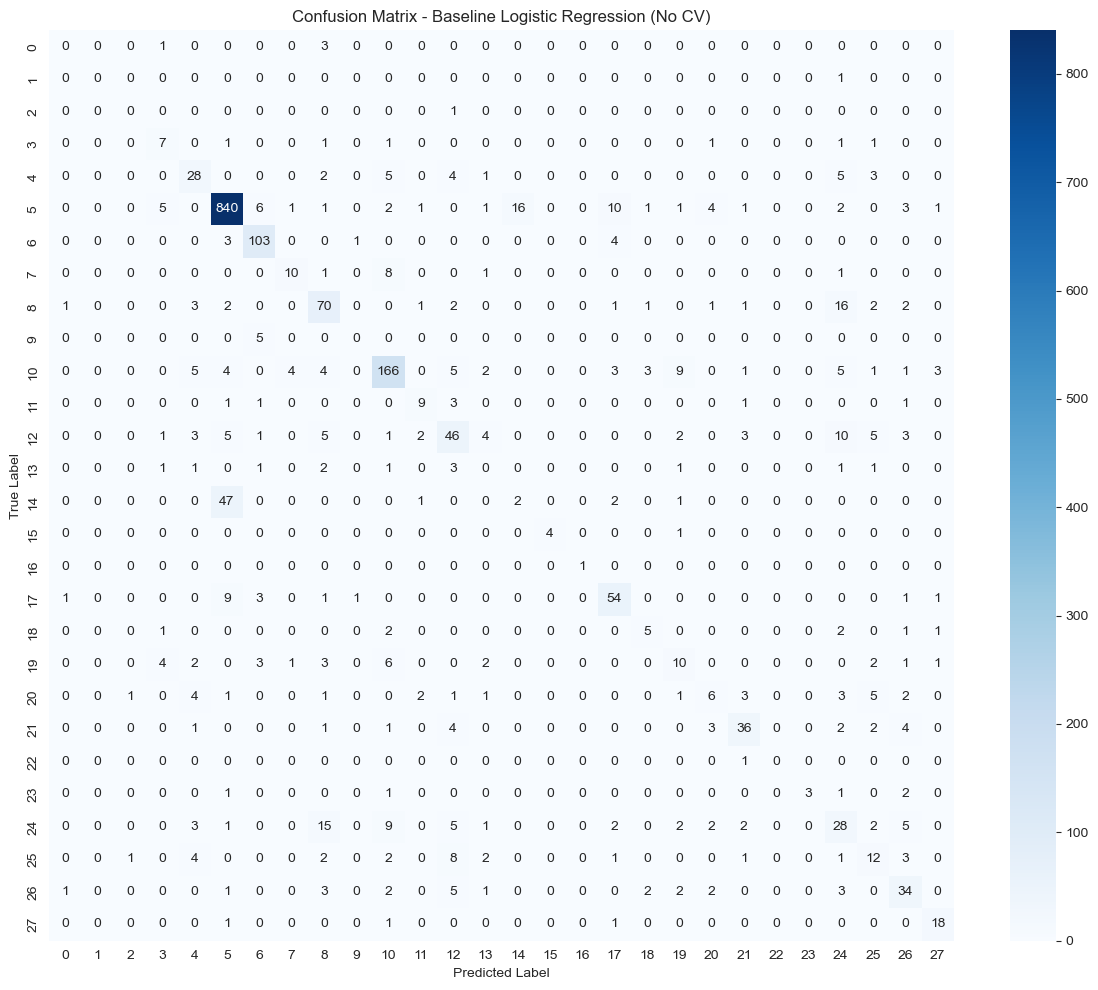

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline: Load and Standardize Full Feature Set
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Split train/val without CV
X_train, X_val, y_train, y_val = train_test_split(
    X_std, y, test_size=0.2, stratify=y, random_state=42
)

# Baseline Logistic Regression Evaluation
model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    solver='lbfgs',
    penalty='l2',
    random_state=42
)

print("[INFO] Training model...")
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

macro_f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
conf_matrix = confusion_matrix(y_val, y_pred, labels=np.arange(28))

# Baseline Results Output
print("\nBaseline Logistic Regression (All Features, No Class Weight, No CV)")
print(f"Macro Avg F1-score:    {macro_f1:.4f}")
print(f"Weighted Avg F1-score: {weighted_f1:.4f}\n")

# Print per-class classification report
print("Classification Report (per class):")
print(classification_report(y_val, y_pred, digits=4, zero_division=0))

# Show annotated confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Baseline Logistic Regression (No CV)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# === Load and Standardize Full Feature Set ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

print(f"[INFO] Loaded data: {X.shape[0]} samples, {X.shape[1]} features")

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# === Split train/val ===
print("[INFO] Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_std, y, test_size=0.2, stratify=y, random_state=42
)
print(f"[INFO] Train: {X_train.shape}, Validation: {X_val.shape}")

# === A. Original Logistic Regression ===
print("[INFO] Training A. Original Logistic Regression...")
model_original = LogisticRegression(
    multi_class='multinomial', max_iter=1000, solver='saga', penalty='l2', random_state=42
)
model_original.fit(X_train, y_train)
y_pred_orig = model_original.predict(X_val)

# === B. Logistic Regression with SMOTE ===
print("[INFO] Applying SMOTE...")
k = max(1, min(min(Counter(y_train).values()) - 1, 5))
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=k).fit_resample(X_train, y_train)
print(f"[INFO] After SMOTE: {X_smote.shape[0]} samples")
print("[INFO] Training B. SMOTE Logistic Regression...")
model_smote = LogisticRegression(
    multi_class='multinomial', max_iter=1000, solver='saga', penalty='l2', random_state=42
)
model_smote.fit(X_smote, y_smote)
y_pred_smote = model_smote.predict(X_val)

# === C. Logistic Regression with Class Weights ===
print("[INFO] Computing class weights...")
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))
print("[INFO] Training C. Weighted Logistic Regression...")
model_weighted = LogisticRegression(
    multi_class='multinomial', max_iter=1000, solver='saga', penalty='l2', random_state=42,
    class_weight=class_weights
)
model_weighted.fit(X_train, y_train)
y_pred_weighted = model_weighted.predict(X_val)

# === Evaluation Function ===
def evaluate_strategy(name, y_true, y_pred):
    macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"\n{name}")
    print(f"Macro Avg F1-score:    {macro:.4f}")
    print(f"Weighted Avg F1-score: {weighted:.4f}")
    print("Classification Report (per class):")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(28))
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

# === Run All Evaluations ===
for name, pred in tqdm([
    ("A. Original Logistic Regression", y_pred_orig),
    ("B. SMOTE Logistic Regression", y_pred_smote),
    ("C. Weighted Logistic Regression", y_pred_weighted)
], desc="Evaluating Models"):
    evaluate_strategy(name, y_val, pred)


Evaluating Sequences: 100%|██████████| 5/5 [47:03<00:00, 564.74s/it]


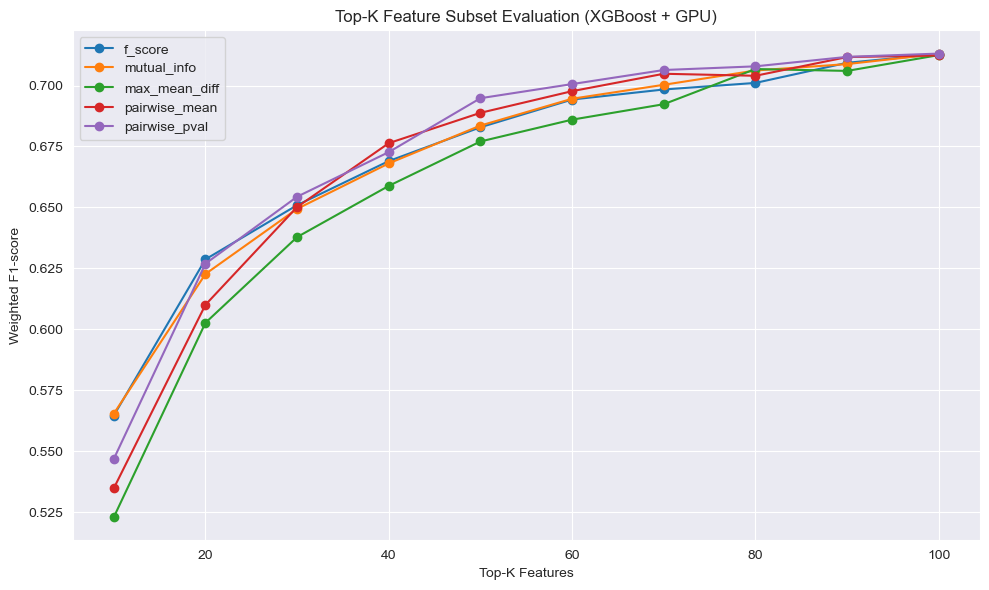


Best Top-K per feature sequence:
f_score              -> Top-100, Weighted F1 = 0.7129
mutual_info          -> Top-100, Weighted F1 = 0.7130
max_mean_diff        -> Top-100, Weighted F1 = 0.7125
pairwise_mean        -> Top-100, Weighted F1 = 0.7123
pairwise_pval        -> Top-100, Weighted F1 = 0.7131


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# === Step 1: 加载数据 ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

# 标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === Step 2: 加载特征序列 ===
def load_feature_indices(filepath, column="feature_idx"):
    return pd.read_csv(filepath)[column].astype(int).tolist()

feature_rankings = {
    "f_score": load_feature_indices("../output/f_score_with_p_value.csv"),
    "mutual_info": load_feature_indices("../output/mutual_info_global.csv"),
    "max_mean_diff": load_feature_indices("../output/max_class_mean_diff.csv"),
    "pairwise_mean": load_feature_indices("../output/pairwise_mean_diff_top_10_features.csv"),
    "pairwise_pval": load_feature_indices("../output/pairwise_p_value_top_10_features.csv")
}

# === Step 3: 手动实现 CV + XGBoost GPU 训练 ===
def evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=None, cv=5):
    if k_list is None:
        k_list = list(range(10, 101, 10))

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, ranking in tqdm(feature_rankings.items(), desc="Evaluating Sequences"):
        scores = []

        for k in tqdm(k_list, desc=f"{name} Top-K", leave=False):
            selected_features = ranking[:k]
            X_k = X[:, selected_features]
            f1_scores = []

            for train_idx, val_idx in skf.split(X_k, y):
                X_train_cv, X_val_cv = X_k[train_idx], X_k[val_idx]
                y_train_cv, y_val_cv = y[train_idx], y[val_idx]

                model = XGBClassifier(
                    objective="multi:softprob",
                    num_class=28,
                    eval_metric="mlogloss",
                    use_label_encoder=False,
                    random_state=42,
                    tree_method="gpu_hist",
                    predictor="gpu_predictor",
                    verbosity=0
                )

                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_val_cv)
                f1 = f1_score(y_val_cv, y_pred, average="weighted", zero_division=0)
                f1_scores.append(f1)

            scores.append((k, np.mean(f1_scores)))
        results[name] = scores
    return results

# === Step 4: 绘图函数 ===
def plot_topk_f1_curves(results):
    plt.figure(figsize=(10, 6))
    for name, score_list in results.items():
        k_vals, f1_vals = zip(*score_list)
        plt.plot(k_vals, f1_vals, marker='o', label=name)

    plt.xlabel("Top-K Features")
    plt.ylabel("Weighted F1-score")
    plt.title("Top-K Feature Subset Evaluation (XGBoost + GPU)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 5: 执行评估并绘图 ===
k_values = list(range(10, 101, 10))
results = evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=k_values)
plot_topk_f1_curves(results)

# === Step 6: 输出每组排序的最佳 top-k 与 F1-score ===
best = {name: max(score_list, key=lambda x: x[1]) for name, score_list in results.items()}
print("\nBest Top-K per feature sequence:")
for name, (k, score) in best.items():
    print(f"{name:20s} -> Top-{k:3d}, Weighted F1 = {score:.4f}")

Evaluating Sequences: 100%|██████████| 5/5 [39:36<00:00, 475.26s/it]


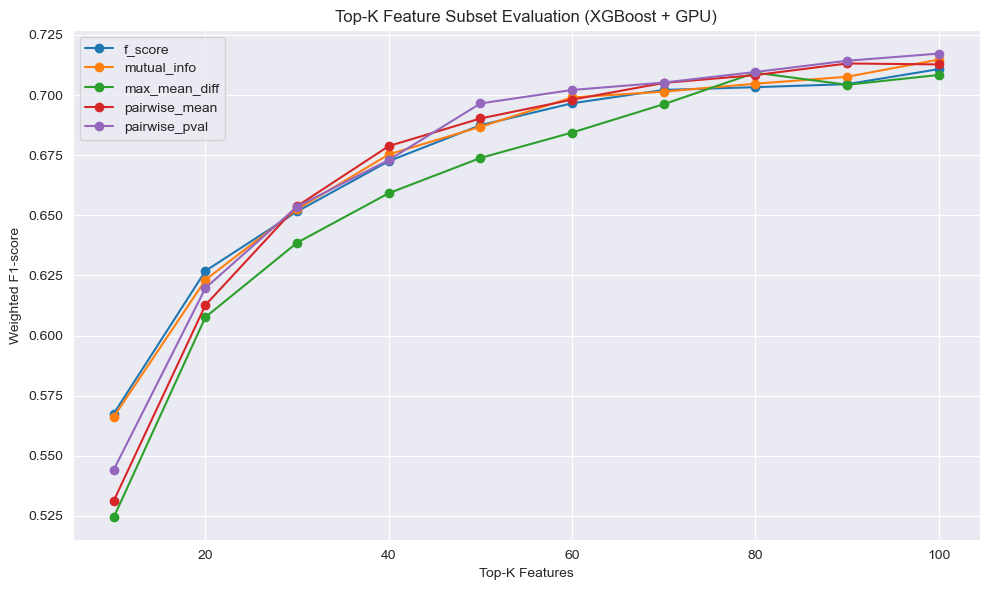


Best Top-K per feature sequence:
f_score              -> Top-100, Weighted F1 = 0.7108
mutual_info          -> Top-100, Weighted F1 = 0.7147
max_mean_diff        -> Top- 80, Weighted F1 = 0.7093
pairwise_mean        -> Top- 90, Weighted F1 = 0.7131
pairwise_pval        -> Top-100, Weighted F1 = 0.7172


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# === Step 1: 加载数据 ===
X = pd.read_csv("../data/X_train.csv", skiprows=1, header=None).values
y = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()

# === Step 1.5: IQR裁剪异常值 ===
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

X = np.where(X < lower_bound, lower_bound, X)
X = np.where(X > upper_bound, upper_bound, X)

# === Step 2: RobustScaler 标准化 ===
scaler = RobustScaler()
X = scaler.fit_transform(X)

# === Step 3: 加载特征序列 ===
def load_feature_indices(filepath, column="feature_idx"):
    return pd.read_csv(filepath)[column].astype(int).tolist()

feature_rankings = {
    "f_score": load_feature_indices("../output/f_score_with_p_value.csv"),
    "mutual_info": load_feature_indices("../output/mutual_info_global.csv"),
    "max_mean_diff": load_feature_indices("../output/max_class_mean_diff.csv"),
    "pairwise_mean": load_feature_indices("../output/pairwise_mean_diff_top_10_features.csv"),
    "pairwise_pval": load_feature_indices("../output/pairwise_p_value_top_10_features.csv")
}

# === Step 4: 手动实现 CV + XGBoost GPU 训练 ===
def evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=None, cv=5):
    if k_list is None:
        k_list = list(range(10, 101, 10))

    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    for name, ranking in tqdm(feature_rankings.items(), desc="Evaluating Sequences"):
        scores = []

        for k in tqdm(k_list, desc=f"{name} Top-K", leave=False):
            selected_features = ranking[:k]
            X_k = X[:, selected_features]
            f1_scores = []

            for train_idx, val_idx in skf.split(X_k, y):
                X_train_cv, X_val_cv = X_k[train_idx], X_k[val_idx]
                y_train_cv, y_val_cv = y[train_idx], y[val_idx]

                model = XGBClassifier(
                    objective="multi:softprob",
                    num_class=28,
                    eval_metric="mlogloss",
                    use_label_encoder=False,
                    random_state=42,
                    tree_method="gpu_hist",
                    predictor="gpu_predictor",
                    verbosity=0
                )

                model.fit(X_train_cv, y_train_cv)
                y_pred = model.predict(X_val_cv)
                f1 = f1_score(y_val_cv, y_pred, average="weighted", zero_division=0)
                f1_scores.append(f1)

            scores.append((k, np.mean(f1_scores)))
        results[name] = scores
    return results

# === Step 5: 绘图函数 ===
def plot_topk_f1_curves(results):
    plt.figure(figsize=(10, 6))
    for name, score_list in results.items():
        k_vals, f1_vals = zip(*score_list)
        plt.plot(k_vals, f1_vals, marker='o', label=name)

    plt.xlabel("Top-K Features")
    plt.ylabel("Weighted F1-score")
    plt.title("Top-K Feature Subset Evaluation (XGBoost + GPU)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 6: 执行评估并绘图 ===
k_values = list(range(10, 101, 10))
results = evaluate_topk_f1_gpu_manualcv(X, y, feature_rankings, k_list=k_values)
plot_topk_f1_curves(results)

# === Step 7: 输出每组排序的最佳 top-k 与 F1-score ===
best = {name: max(score_list, key=lambda x: x[1]) for name, score_list in results.items()}
print("\nBest Top-K per feature sequence:")
for name, (k, score) in best.items():
    print(f"{name:20s} -> Top-{k:3d}, Weighted F1 = {score:.4f}")